# 課題2 平均誤差発達率

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# 4次Runge-Kutta法

In [2]:
def RungeKutta4(initial, time, model, F):
    """
    F :
        Forcing constant, to be used in Lorenz96
    kwargs : 
        modelに渡す x 以外の変数を指定
    """
    dt = time[1] - time[0]
    states = [initial]
    x = initial
    for t in time[:-1]:
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        states.append(x)
    states = np.stack(states)
    return states

# Lorenz-96

In [3]:
def Lorenz96(x0, F):
    x = np.zeros(x0.shape[0]+3)
    # 周期的なxの表現をつくる
    x[2:-1] = x0 # index 2がもとのxのindex 0, index -2がもとのxのN
    x[:2] = x0[-2:] # index 0,1 がもとのxのindex N-1, N
    x[-1] = x0[0] # index -1 がもとのxのindex 0
    
    dxdt = (x[3:] - x[:-3]) * x[1:-2] - x[2:-1] + F
    return dxdt

def L96(x, F, N=40):
    """
    Lorenz 96 model with constant forcing.
    Cited by "https://en.wikipedia.org/wiki/Lorenz_96_model"
    
    Parameters
    ----------
    x : 
        variables
    F :
       Forcing constant 
    N : int
        number of sites
    """
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

73時間ステップ(365日分)を遷移過程として、
以降の時間はアトラクター上にいるとする

時間刻みは0.01,1000時間ステップまで計算

In [4]:
N = 40
F = 8.0
time = np.arange(0.0, 1000.0, 0.01)

In [5]:
import time as time1

In [6]:
# 初期値をわずかに変えたもの
ut = time1.time()

x1 = np.full(N, F)
x1[19] += F * 0.001
xs1 = RungeKutta4(x1, time, Lorenz96, F=F)

print(time1.time() - ut)

4.826220750808716


In [7]:
xs1.shape

(100000, 40)

一様乱数を用いて、7300~99000の整数を一つ出力して、その時間を出発点とする。
平均0, 分散0.1の正規乱数を40個作り、そのベクトルを誤差とする。

10時間ステップ計算して、誤差発達率を計算する。

誤差発達率はL2ノルムを用いて計算する

これを10000回繰り返して、平均の誤差発達率を計算する。

In [8]:
time = np.arange(0, 1, 0.01)
error1 = np.zeros(100)
for i in range(10000):
    t = np.random.randint(7300, 99000)
    dx = np.random.normal(0, 0.1, 40)
    x0 = xs1[t] + dx
    dx0 = np.linalg.norm(dx, 2)
    xs2 = RungeKutta4(x0, time, Lorenz96, F=F)
    for j in range(100):
        dx1 = np.linalg.norm(xs1[t+j] - xs2[j], 2)
        error1[j] += dx1 / dx0
error1 /= 10000


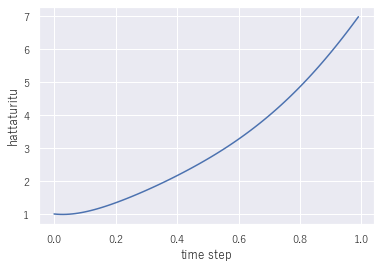

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("time step")
ax.set_ylabel("hattaturitu")
ax.plot(time, error1)
plt.show()

In [27]:
for i in range(100):
    if error1[i] > 4:
        print("誤差の倍化時間:{} ({}日)".format(i, i / 20))
        break


誤差の倍化時間:71 (3.55日)


In [11]:
from scipy.optimize import curve_fit

In [20]:
def exponetial_func_fit(time, lam):
    return np.exp(lam*time)

[0.39377756]


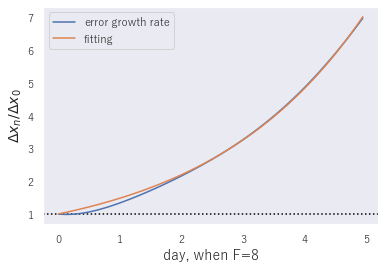

In [31]:
time = np.arange(0, 1, 0.01)
time *= 5

grow = error1
fs = 14

param, cov = curve_fit(exponetial_func_fit, time, error1)
print(param)
grow_fit = exponetial_func_fit(time, param[0])

plt.axhline(1, linestyle="dotted", color="black")
plt.plot(time, grow, label = "error growth rate")
plt.plot(time, grow_fit, label = "fitting")
plt.grid()
# plt.xlim(0,3)
# plt.ylim(0,4)
plt.xlabel("day, when F=8", fontsize=fs)
plt.ylabel("$\Delta{x}_n/\Delta{x}_0$", fontsize=fs)
plt.legend()
plt.show()

plt.savefig(r"C:\Users\AwanoShota\OneDrive\ドキュメント\kojinyou\授業\データ同化A\fitting.png")


## 異なる誤差の与え方での実験

\[-0.1, 0.1\)の一様乱数

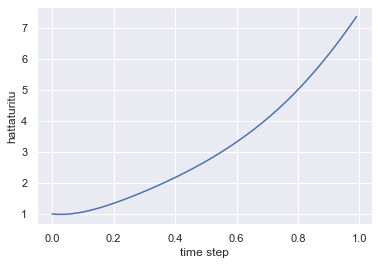

In [20]:
time = np.arange(0, 1, 0.01)
error2 = np.zeros(100)
for i in range(10000):
    t = np.random.randint(7300, 99000)
    dx = 0.2 * np.random.rand(40) - 0.1
    x0 = xs1[t] + dx
    dx0 = np.linalg.norm(dx, 2)
    xs2 = RungeKutta4(x0, time, Lorenz96, F=F)
    for j in range(100):
        dx1 = np.linalg.norm(xs1[t+j] - xs2[j], 2)
        error2[j] += dx1 / dx0
error2 /= 10000
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("time step")
ax.set_ylabel("hattaturitu")
ax.plot(time, error2)
plt.show()

In [21]:
for i in range(100):
    if error2[i] > 2:
        print("誤差の倍化時間:{} ({}日)".format(i, i / 20))
        break

誤差の倍化時間:37 (1.85日)


一点に、平均0, 分散0.1の正規乱数の誤差を与える。

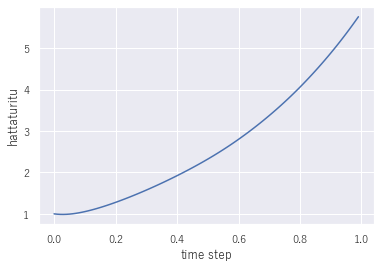

In [29]:
time = np.arange(0, 1, 0.01)
error3 = np.zeros(100)
for i in range(10000):
    t = np.random.randint(7300, 99000)
    p = np.random.randint(0, 39)
    dx = np.zeros(40)
    dx[p] = np.random.normal(0, 0.1)
    x0 = xs1[t] + dx
    dx0 = np.linalg.norm(dx, 2)
    xs2 = RungeKutta4(x0, time, Lorenz96, F=F)
    for j in range(100):
        dx1 = np.linalg.norm(xs1[t+j] - xs2[j], 2)
        error3[j] += dx1 / dx0
error3 /= 10000
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("time step")
ax.set_ylabel("hattaturitu")
ax.plot(time, error3)
plt.show()

In [30]:
for i in range(100):
    if error3[i] > 2:
        print("誤差の倍化時間:{} ({}日)".format(i, i / 20))
        break

誤差の倍化時間:43 (2.15日)


In [26]:
#

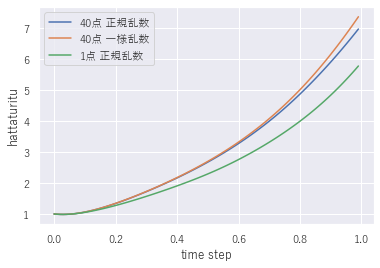

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("time step")
ax.set_ylabel("hattaturitu")
ax.plot(time, error1, label = "40点 正規乱数")
ax.plot(time, error2, label = "40点 一様乱数")
ax.plot(time, error3, label = "1点 正規乱数")
plt.legend()
plt.show()

分散を小さくしたもの

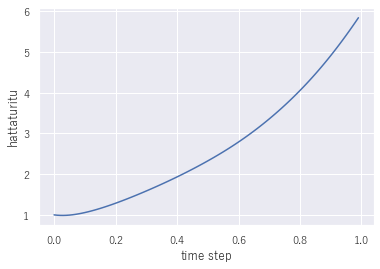

In [31]:
time = np.arange(0, 1, 0.01)
error4 = np.zeros(100)
for i in range(10000):
    t = np.random.randint(7300, 99000)
    p = np.random.randint(0, 39)
    dx = np.zeros(40)
    dx[p] = np.random.normal(0, 0.001)
    x0 = xs1[t] + dx
    dx0 = np.linalg.norm(dx, 2)
    xs2 = RungeKutta4(x0, time, Lorenz96, F=F)
    for j in range(100):
        dx1 = np.linalg.norm(xs1[t+j] - xs2[j], 2)
        error4[j] += dx1 / dx0
error4 /= 10000
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("time step")
ax.set_ylabel("hattaturitu")
ax.plot(time, error4)
plt.show()

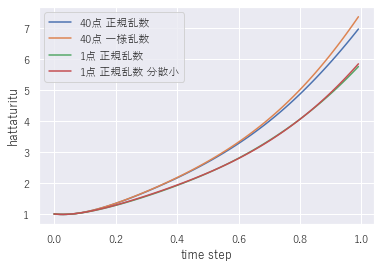

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("time step")
ax.set_ylabel("hattaturitu")
ax.plot(time, error1, label = "40点 正規乱数")
ax.plot(time, error2, label = "40点 一様乱数")
ax.plot(time, error3, label = "1点 正規乱数")
ax.plot(time, error4, label = "1点 正規乱数 分散小")
plt.legend()
plt.show()